In [1]:
#pip install prophet

In [2]:
import numpy as np
import pandas as pd
import pandasql as ps
import math
import itertools 

#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set(font="Arial",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})

In [3]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [4]:
# Load Data 
file_path = "/Users/bg/Desktop/Data_Analyst /10.1048 CUTANA CUT&RUN.csv"
df = pd.read_csv(file_path)

df.head()

,Cat No,ds,y
0,14-1048,1/1/23,115
1,14-1048,2/1/23,137
2,14-1048,3/1/23,137
3,14-1048,4/1/23,134
4,14-1048,5/1/23,134


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Cat No  13 non-null     object
 1   ds      13 non-null     object
 2   y       13 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 440.0+ bytes


In [6]:
# Change the ds column to datetime for prophet
df["ds"]=pd.DatetimeIndex(df['ds'])
df.dtypes

Cat No            object
ds        datetime64[ns]
y                  int64
dtype: object

In [7]:
#Visualize the change in ds column
df

,Cat No,ds,y
0,14-1048,2023-01-01,115
1,14-1048,2023-02-01,137
2,14-1048,2023-03-01,137
3,14-1048,2023-04-01,134
4,14-1048,2023-05-01,134
5,14-1048,2023-06-01,167
6,14-1048,2023-07-01,105
7,14-1048,2023-08-01,129
8,14-1048,2023-09-01,124
9,14-1048,2023-10-01,139


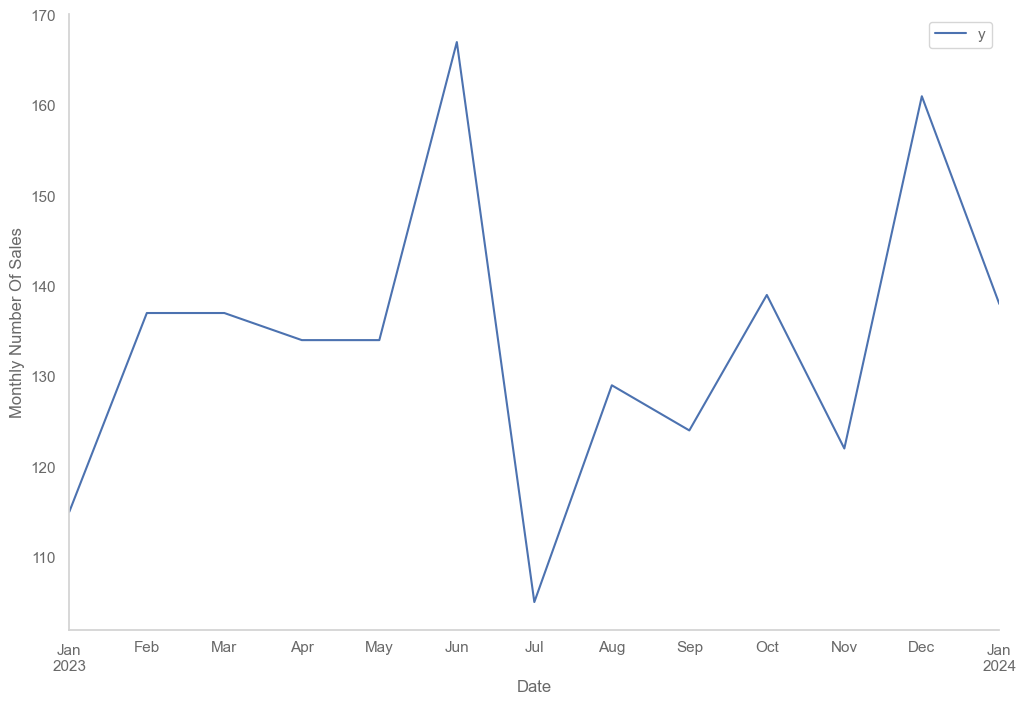

In [8]:
# Visualize the data 
ax=df.set_index('ds').plot(figsize=(12,8))
ax.set_ylabel('Monthly Number Of Sales')
ax.set_xlabel('Date')
plt.show()

In [9]:
#Set the uncertainty interval to 95%. (defalut is 80%)
my_model = Prophet(interval_width=0.95)


In [10]:
#Call the fit method with iur Dataframe as the input 
my_model.fit(df)

11:29:06 - cmdstanpy - INFO - Chain [1] start processing
11:29:06 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
# Allow prophet to creat a new dataframe with a ds column that will hold the date for which we want predictions
#periods= is the number of datestamps we want for the future forecasting, freq indicates months, days, weeks. MS=month 
future_dates = my_model.make_future_dataframe(periods=12, freq="MS")
future_dates.head()

,ds
0,2023-01-01
1,2023-02-01
2,2023-03-01
3,2023-04-01
4,2023-05-01


In [12]:
forecast = my_model.predict(future_dates)
forecast[['ds','yhat','yhat_lower','yhat_upper']]


,ds,yhat,yhat_lower,yhat_upper
0,2023-01-01,128.87,99.16,159.33
1,2023-02-01,129.74,99.18,163.22
2,2023-03-01,130.54,101.56,159.87
3,2023-04-01,131.41,100.33,159.98
4,2023-05-01,132.26,101.57,161.36
5,2023-06-01,133.14,102.70,164.36
6,2023-07-01,133.99,104.43,164.01
7,2023-08-01,134.87,102.42,163.91
8,2023-09-01,135.74,104.63,166.10
9,2023-10-01,136.59,105.37,167.64


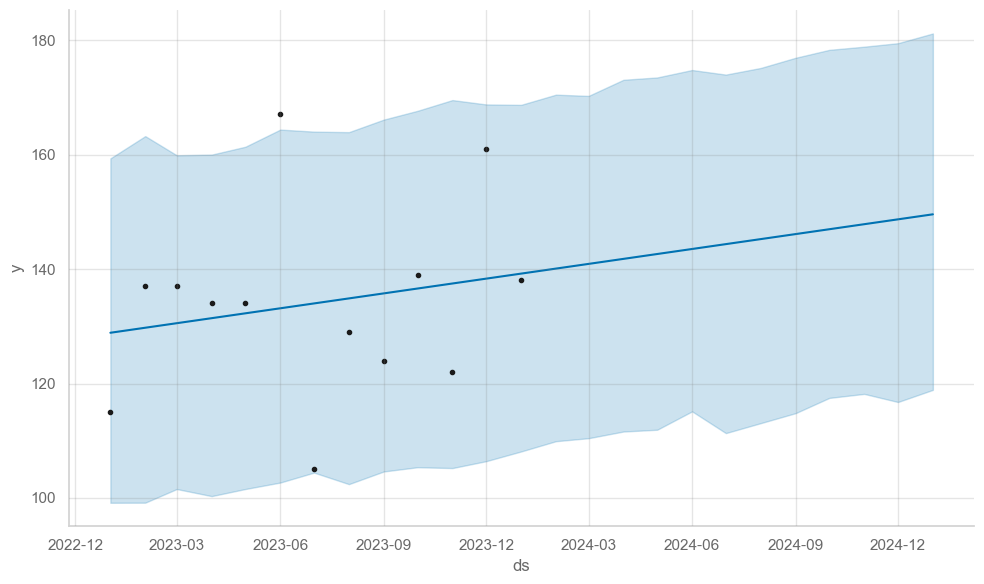

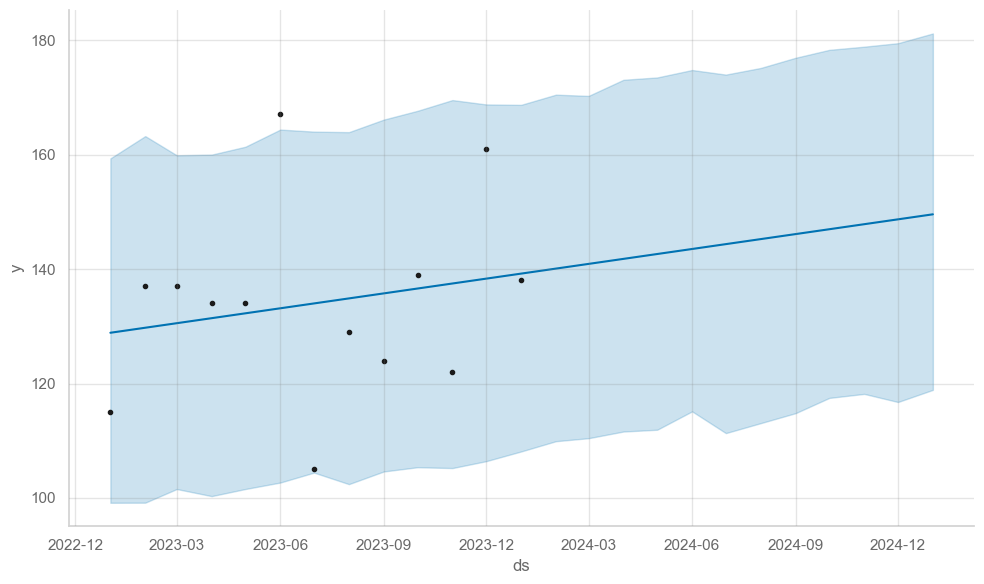

In [13]:
#Prophet plot. Black dots show observed values of the time series. 
#Blue line shows forecasted values and shaded region is the uncertainty intervals of our forecast. 
my_model.plot(forecast, uncertainty=True)

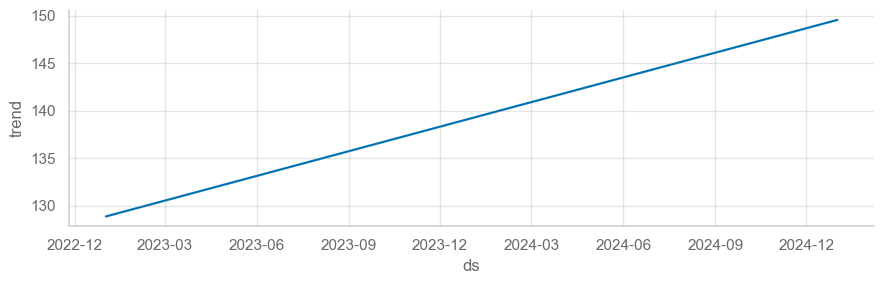

In [14]:
# Return components of our forecasts
fig1 = my_model.plot_components(forecast)